In [ ]:
!pip install einops ema_pytorch mat73 numpy scikit_learn torch tqdm --quiet

In [4]:
!git clone https://github.com/diffe2023/Diff-E.git

Cloning into 'Diff-E'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 160 (delta 43), reused 27 (delta 26), pack-reused 105 (from 1)
Receiving objects: 100% (160/160), 53.41 KiB | 3.56 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [5]:
!git clone https://github.com/scottwellington/FEIS.git

Cloning into 'FEIS'...
remote: Enumerating objects: 1452, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1452 (delta 12), reused 16 (delta 12), pack-reused 1432 (from 1)
Receiving objects: 100% (1452/1452), 1.52 GiB | 93.55 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Updating files: 100% (1574/1574), done.


In [6]:
!git clone -b attentionpool --single-branch https://github.com/eddieguo-1128/idl_team2.git

Cloning into 'idl_team2'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 177 (delta 24), reused 10 (delta 9), pack-reused 146 (from 1)
Receiving objects: 100% (177/177), 843.56 KiB | 19.62 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

In [7]:
!ls


Diff-E	DiffE.ipynb  FEIS  idl_team2  ondemand


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/diffusion-DiffE')

In [ ]:

sys.path.append('Diff-E')

In [8]:
import sys
sys.path.append('idl_team2/diffusion-DiffE')

In [7]:
import os
files = os.listdir('idl_team2/diffusion-DiffE')
print(files)

['main.py', '.DS_Store', 'models.py', 'utils.py', 'evaluation.py']


In [ ]:
files = os.listdir('/content/drive/MyDrive/diffusion-DiffE')
print(files)

In [9]:
import zipfile
import os
def unzip_data(root_dir: str):
    """
    Traverse each subject folder in root_dir and extract any ZIP files.
    Each ZIP is extracted into a folder with the same name (without the .zip extension).
    """
    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject)
        if os.path.isdir(subject_path):
            for item in os.listdir(subject_path):
                if item.lower().endswith('.zip'):
                    zip_path = os.path.join(subject_path, item)
                    extract_folder = os.path.join(subject_path, item[:-4])
                    if not os.path.exists(extract_folder):
                        print(f"Extracting {zip_path} to {extract_folder}...")
                        with zipfile.ZipFile(zip_path, 'r') as zf:
                            zf.extractall(extract_folder)
                    else:
                        print(f"Folder {extract_folder} already exists. Skipping extraction.")

In [10]:
# unzip_data("/content/drive/MyDrive/FEIS/data_eeg")
unzip_data("FEIS/data_eeg")

Extracting FEIS/data_eeg/01/thinking.zip to FEIS/data_eeg/01/thinking...
Extracting FEIS/data_eeg/01/articulators.zip to FEIS/data_eeg/01/articulators...
Extracting FEIS/data_eeg/01/stimuli.zip to FEIS/data_eeg/01/stimuli...
Extracting FEIS/data_eeg/01/speaking.zip to FEIS/data_eeg/01/speaking...
Extracting FEIS/data_eeg/01/full_eeg.zip to FEIS/data_eeg/01/full_eeg...
Extracting FEIS/data_eeg/01/resting.zip to FEIS/data_eeg/01/resting...
Extracting FEIS/data_eeg/02/thinking.zip to FEIS/data_eeg/02/thinking...
Extracting FEIS/data_eeg/02/articulators.zip to FEIS/data_eeg/02/articulators...
Extracting FEIS/data_eeg/02/stimuli.zip to FEIS/data_eeg/02/stimuli...
Extracting FEIS/data_eeg/02/speaking.zip to FEIS/data_eeg/02/speaking...
Extracting FEIS/data_eeg/02/full_eeg.zip to FEIS/data_eeg/02/full_eeg...
Extracting FEIS/data_eeg/02/resting.zip to FEIS/data_eeg/02/resting...
Extracting FEIS/data_eeg/03/thinking.zip to FEIS/data_eeg/03/thinking...
Extracting FEIS/data_eeg/03/articulators.zi

In [ ]:
!pip install wandb

# import wandb


In [11]:
import wandb

In [12]:
import os
import sys
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, top_k_accuracy_score
from tqdm import tqdm
from ema_pytorch import EMA
import wandb
import matplotlib.pyplot as plt

In [82]:
wandb.init(
    project="diffE-EEG-Imagined-Speech",
    config={
        "epochs": 500,
        "alpha": 0.1,
        "batch_size_train": 32,
        "batch_size_test": 260,
        "base_lr": 9e-5,
        "max_lr": 1.5e-3,
        "scheduler_step": 150,
        "scheduler_gamma": 0.9998,
        "seed": 42,
        "num_classes": 16,
        "ddpm_dim": 128,
        "encoder_dim": 256,
        "fc_dim": 512,
        "n_T": 1000,
        "test_size": 0.2,
        "data_root": "FEIS/data_eeg",
        "subject_ids": [str(i).zfill(2) for i in range(1, 22)],
        "task_type": "thinking",
        "window_len": 256,
        "window_step": 128,
        "target_channels": 16,
    }
)
config = wandb.config

In [43]:

!ls FEIS/data_eeg/01/resting


resting.csv


In [83]:
CONFIG = {
    "DATA_ROOT": config.data_root,
    "SUBJECT_IDS": config.subject_ids,
    "TASK_TYPE": config.task_type,
    "WINDOW_LEN": config.window_len,
    "WINDOW_STEP": config.window_step,
    "TARGET_CHANNELS": config.target_channels,
    "TEST_SIZE": config.test_size,
    "BATCH_SIZE_TRAIN": config.batch_size_train,
    "BATCH_SIZE_TEST": config.batch_size_test,
    "SEED": config.seed,
    "NUM_EPOCHS": config.epochs,
    "NUM_CLASSES": config.num_classes,
    "DDPM_DIM": config.ddpm_dim,
    "ENCODER_DIM": config.encoder_dim,
    "FC_DIM": config.fc_dim,
    "N_T": config.n_T,
    "BASE_LR": config.base_lr,
    "MAX_LR": config.max_lr,
    "ALPHA": config.alpha,
    "EMA_BETA": 0.95,
    "SCHEDULER_STEP": config.scheduler_step,
    "SCHEDULER_GAMMA": config.scheduler_gamma,
    "split_config": {
        "train": [
            {"subject": "01", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "02", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "03", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "04", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "05", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "06", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "07", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "08", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "09", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "10", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "11", "task": "thinking", "filename": "thinking.csv"}
        ],
        "val": [
            {"subject": "01", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "02", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "03", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "04", "task": "thinking", "filename": "thinking.csv"}
        ],
        "test_seen": [
            {"subject": "05", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "06", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "07", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "08", "task": "thinking", "filename": "thinking.csv"}
        ],
        "test_unseen": [
            {"subject": "09", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "10", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "11", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "12", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "13", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "14", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "15", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "16", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "17", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "18", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "19", "task": "speaking",  "filename": "speaking.csv"},
            {"subject": "20", "task": "thinking", "filename": "thinking.csv"},
            {"subject": "21", "task": "speaking",  "filename": "speaking.csv"}
        ]

}
}


DATA SPLIT

In [68]:
def load_single_subject(data_root, record, selected_channels=None):
    """
    Load EEG data for one record.
    record: dict with keys "subject", "task", and "filename".
    """
    subject = record["subject"]
    task = record["task"]
    filename = record["filename"]
    csv_path = os.path.join(data_root, subject, task, filename)
    print("csv_path",csv_path)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File not found: {csv_path}")
    
    eeg_df = pd.read_csv(csv_path)
    non_eeg_cols = ['Time:256Hz', 'Epoch', 'Label', 'Stage', 'Flag']
    channels = selected_channels or [col for col in eeg_df.columns if col not in non_eeg_cols]
    data = eeg_df[channels].values
    
    # Extract labels
    labels = eeg_df['Label'].values if 'Label' in eeg_df.columns else np.zeros(len(eeg_df))
    unique_labels = np.unique(labels)
    label_map = {l: i for i, l in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[l] for l in labels])
    return data, encoded_labels

In [69]:
def load_split(split_list, data_root, selected_channels=None):
    all_features = []
    all_targets = []
    for record in split_list:
        try:
            data, labels = load_single_subject(data_root, record, selected_channels)
            features, targets = create_windows(data, labels, CONFIG["WINDOW_LEN"], CONFIG["WINDOW_STEP"])
            all_features.append(features)
            all_targets.append(targets)
            print(f"Loaded {record}")
        except Exception as e:
            print(f"Failed to load {record}: {str(e)}")
    if not all_features:
        raise RuntimeError("No data loaded for this split!")
    return torch.cat(all_features), torch.cat(all_targets)

In [70]:
def create_loaders_from_config(split_config, data_root, selected_channels=None):
    from utils import EEGDataset
    train_features, train_targets = load_split(split_config["train"], data_root, selected_channels)
    val_features, val_targets = load_split(split_config["val"], data_root, selected_channels)
    test_seen_features, test_seen_targets = load_split(split_config["test_seen"], data_root, selected_channels)
    test_unseen_features, test_unseen_targets = load_split(split_config["test_unseen"], data_root, selected_channels)
    
    # Pad features as needed.
    train_features = pad_channels(train_features, CONFIG["TARGET_CHANNELS"])
    val_features   = pad_channels(val_features, CONFIG["TARGET_CHANNELS"])
    test_seen_features = pad_channels(test_seen_features, CONFIG["TARGET_CHANNELS"])
    test_unseen_features = pad_channels(test_unseen_features, CONFIG["TARGET_CHANNELS"])
    
    train_loader = DataLoader(EEGDataset(train_features, train_targets), batch_size=CONFIG["BATCH_SIZE_TRAIN"], shuffle=True)
    val_loader = DataLoader(EEGDataset(val_features, val_targets), batch_size=CONFIG["BATCH_SIZE_TEST"], shuffle=False)
    test_loader = DataLoader(EEGDataset(test_seen_features, test_seen_targets), batch_size=CONFIG["BATCH_SIZE_TEST"], shuffle=False)
    test_unseen_loader = DataLoader(EEGDataset(test_unseen_features, test_unseen_targets), batch_size=CONFIG["BATCH_SIZE_TEST"], shuffle=False)
    
    return train_loader, val_loader, test_seen_loader, test_unseen_loader

# Create data loaders using the split configuration:
train_loader, val_loader, test_loader, test_unseen_loader = create_loaders_from_config(CONFIG["split_config"], CONFIG["DATA_ROOT"])

csv_path FEIS/data_eeg/01/thinking/thinking.csv
Loaded {'subject': '01', 'task': 'thinking', 'filename': 'thinking.csv'}
csv_path FEIS/data_eeg/02/speaking/speaking.csv
Loaded {'subject': '02', 'task': 'speaking', 'filename': 'speaking.csv'}
csv_path FEIS/data_eeg/03/thinking/thinking.csv
Loaded {'subject': '03', 'task': 'thinking', 'filename': 'thinking.csv'}
csv_path FEIS/data_eeg/04/speaking/speaking.csv
Loaded {'subject': '04', 'task': 'speaking', 'filename': 'speaking.csv'}
csv_path FEIS/data_eeg/05/thinking/thinking.csv
Loaded {'subject': '05', 'task': 'thinking', 'filename': 'thinking.csv'}
csv_path FEIS/data_eeg/06/speaking/speaking.csv
Loaded {'subject': '06', 'task': 'speaking', 'filename': 'speaking.csv'}
csv_path FEIS/data_eeg/07/thinking/thinking.csv
Loaded {'subject': '07', 'task': 'thinking', 'filename': 'thinking.csv'}
csv_path FEIS/data_eeg/08/speaking/speaking.csv
Loaded {'subject': '08', 'task': 'speaking', 'filename': 'speaking.csv'}
csv_path FEIS/data_eeg/09/thinki

STRATIFIED DATA SPLIT

In [ ]:
# stratified data split load
def load_single_subject(data_root, subject_id, task_type, selected_channels=None):
    """Load EEG data for a single subject."""
    csv_path = os.path.join(data_root, subject_id, task_type, f"{task_type}.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Data file not found: {csv_path}")
    eeg_df = pd.read_csv(csv_path)
    # Columns that are not EEG data.
    non_eeg_cols = ['Time:256Hz', 'Epoch', 'Label', 'Stage', 'Flag']
    channels = selected_channels or [col for col in eeg_df.columns if col not in non_eeg_cols]
    data = eeg_df[channels].values
    labels = eeg_df['Label'].values if 'Label' in eeg_df.columns else np.zeros(len(eeg_df))
    # Map labels to integers.
    unique_labels = np.unique(labels)
    label_map = {l: i for i, l in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[l] for l in labels])
    return data, encoded_labels

In [19]:
def load_all_subjects(config):
    all_features, all_targets = [], []
    data_root = CONFIG["DATA_ROOT"]
    for subject_id in CONFIG["SUBJECT_IDS"]:
        try:
            data, labels = load_single_subject(data_root, subject_id, CONFIG["TASK_TYPE"])
            features, targets = create_windows(data, labels, CONFIG["WINDOW_LEN"], CONFIG["WINDOW_STEP"])
            all_features.append(features)
            all_targets.append(targets)
            print(f"Loaded subject {subject_id}")
        except Exception as e:
            print(f"Skipping subject {subject_id}: {str(e)}")
    if not all_features:
        raise RuntimeError("No data loaded!")
    return torch.cat(all_features), torch.cat(all_targets)

In [21]:
def create_loaders(config):
    # Load and combine all subjects.
    features, targets = load_all_subjects(config)
    features = pad_channels(features, CONFIG["TARGET_CHANNELS"])
    X_train, X_test, y_train, y_test = train_test_split(features, targets, 
                                                         test_size=CONFIG["TEST_SIZE"], 
                                                         shuffle=True, stratify=targets, 
                                                         random_state=CONFIG["SEED"])
    from utils import EEGDataset  # Ensure EEGDataset is imported from your utils module.
    train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=CONFIG["BATCH_SIZE_TRAIN"], shuffle=True)
    test_loader = DataLoader(EEGDataset(X_test, y_test), batch_size=CONFIG["BATCH_SIZE_TEST"], shuffle=False)
    return train_loader, test_loader

In [ ]:
# Create data loaders.
# train_loader, test_loader = create_loaders(CONFIG)

UTILS

In [84]:
def pad_channels(features, target_channels):
    if features.shape[1] >= target_channels:
        return features
    padding = torch.zeros((features.size(0), target_channels - features.size(1), features.size(2)), dtype=features.dtype)
    return torch.cat([features, padding], dim=1)

In [85]:
def create_windows(eeg_data, labels, window_len, window_step):
    """Create time windows (features and targets) from EEG data."""
    features, targets = [], []
    for i in range(0, len(eeg_data) - window_len + 1, window_step):
        features.append(eeg_data[i:i+window_len, :].T)
        targets.append(labels[i + window_len // 2])
    features = torch.tensor(np.array(features), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.long)
    # Normalize features (using provided zscore_norm utility).
    from utils import zscore_norm  # Ensure utils is in PYTHONPATH
    features = zscore_norm(features)
    return features, targets

In [86]:
# %% [code]
def visualize_signals_grid(original, masked, reconstructed, sample_idxs, channel=0):
    """
    Creates a grid figure showing for each sample:
      Column 1: Signal Before (original)
      Column 2: Signal mAsked (noisy/masked)
      Column 3: Signal After (reconstructed)
    """
    num_samples = len(sample_idxs)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples), squeeze=False)
    for i, sample_idx in enumerate(sample_idxs):
        orig_np = original[sample_idx, channel].detach().cpu().numpy()
        masked_np = masked[sample_idx, channel].detach().cpu().numpy()
        recon_np = reconstructed[sample_idx, channel].detach().cpu().numpy()
        axes[i, 0].plot(orig_np, color='blue')
        axes[i, 0].set_title(f"Sample {sample_idx} - Signal Before")
        axes[i, 1].plot(masked_np, color='orange')
        axes[i, 1].set_title(f"Sample {sample_idx} - Signal mAsked")
        axes[i, 2].plot(recon_np, color='green')
        axes[i, 2].set_title(f"Sample {sample_idx} - Signal After")
        for j in range(3):
            axes[i, j].set_xlabel("Time")
            axes[i, j].set_ylabel("Amplitude")
    fig.tight_layout()
    return fig

# (You can test this function later using dummy tensors.)


In [87]:
from models import ConditionalUNet, DDPM, Encoder, Decoder, LinearClassifier, DiffE
from utils import EEGDataset, zscore_norm, minmax_norm

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
in_channels= next(iter(train_loader))[0].shape[1]

ddpm_model = ConditionalUNet(in_channels, n_feat=CONFIG["DDPM_DIM"]).to(device)
ddpm = DDPM(
    nn_model=ddpm_model,
    betas=(1e-6, 1e-2),
    n_T=CONFIG["N_T"],
    device=device
).to(device)
# Initialize DiffE submodules.
encoder = Encoder(in_channels, dim=CONFIG["ENCODER_DIM"]).to(device)
decoder = Decoder(in_channels, n_feat=CONFIG["DDPM_DIM"], encoder_dim=CONFIG["ENCODER_DIM"]).to(device)
fc = LinearClassifier(CONFIG["ENCODER_DIM"], CONFIG["FC_DIM"], emb_dim=CONFIG["NUM_CLASSES"]).to(device)
diffe = DiffE(encoder, decoder, fc).to(device)
fc_ema = EMA(fc, beta=CONFIG["EMA_BETA"], update_after_step=100, update_every=10)

In [90]:
opt_ddpm = optim.RMSprop(ddpm.parameters(), lr=CONFIG["BASE_LR"])
opt_diffe = optim.RMSprop(diffe.parameters(), lr=CONFIG["BASE_LR"])

In [91]:
sched_ddpm = optim.lr_scheduler.CyclicLR(
        opt_ddpm, base_lr=CONFIG["BASE_LR"], max_lr=CONFIG["MAX_LR"],
        step_size_up=CONFIG["SCHEDULER_STEP"], mode="exp_range",
        cycle_momentum=False, gamma=CONFIG["SCHEDULER_GAMMA"]
    )
sched_diffe = optim.lr_scheduler.CyclicLR(
        opt_diffe, base_lr=CONFIG["BASE_LR"], max_lr=CONFIG["MAX_LR"],
        step_size_up=CONFIG["SCHEDULER_STEP"], mode="exp_range",
        cycle_momentum=False, gamma=CONFIG["SCHEDULER_GAMMA"]
    )

In [92]:
def train_epoch(train_loader, ddpm, diffe, fc_ema, opt_ddpm, opt_diffe, sched_ddpm, sched_diffe, device):
    ddpm.train()
    diffe.train()
    total_loss = 0.0
    count = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_cat = F.one_hot(y, num_classes=CONFIG["NUM_CLASSES"]).float().to(device)
        
        # DDPM forward pass.
        opt_ddpm.zero_grad()
        x_hat, down, up, noise, t = ddpm(x)
        loss_ddpm = F.l1_loss(x_hat, x, reduction="none").mean()
        loss_ddpm.backward()
        opt_ddpm.step()
        
        # DiffE forward pass.
        opt_diffe.zero_grad()
        decoder_out, fc_out = diffe(x, (x_hat, down, up, t))
        loss_gap = loss_gap = F.l1_loss(decoder_out, loss_ddpm.detach().expand_as(decoder_out))
        loss_class = F.mse_loss(fc_out, y_cat)
        loss_total = loss_gap + CONFIG["ALPHA"] * loss_class
        loss_total.backward()
        opt_diffe.step()
        fc_ema.update()
        
        sched_ddpm.step()
        sched_diffe.step()
        
        total_loss += loss_total.item()
        count += 1
    avg_loss = total_loss / count
    return avg_loss

In [93]:

def validate_model(val_loader, ddpm, diffe, device):
    ddpm.train()
    diffe.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    count = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_cat = F.one_hot(y, num_classes=CONFIG["NUM_CLASSES"]).float().to(device)
            # Use the same call as in training.
            x_hat, down, up, noise, t = ddpm(x)
            loss_ddpm = F.l1_loss(x_hat, x, reduction="none").mean()
            decoder_out, fc_out = diffe(x, (x_hat, down, up, t))
            loss_gap = F.l1_loss(decoder_out, loss_ddpm.detach().expand_as(decoder_out))
            loss_class = F.mse_loss(fc_out, y_cat)
            loss = loss_gap + CONFIG["ALPHA"] * loss_class
            total_loss += loss.item()
            preds = fc_out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
            count += 1
    avg_loss = total_loss / count
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [94]:
random.seed(CONFIG["SEED"])
torch.manual_seed(CONFIG["SEED"])


In [95]:
import os

# Create a checkpoint directory if it doesn't exist.
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

last_epoch = 0
best_acc = 0.0

In [96]:
# Training loop with tqdm for progress.
for epoch in tqdm(range(last_epoch, CONFIG["NUM_EPOCHS"]), desc="Training Epochs", unit="epoch"):
    train_loss = train_epoch(train_loader, ddpm, diffe, fc_ema, opt_ddpm, opt_diffe, sched_ddpm, sched_diffe, device)
    val_loss, val_acc = validate_model(test_loader, ddpm, diffe, device)
    
    # Log metrics to wandb.
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "lr_ddpm": opt_ddpm.param_groups[0]['lr'],
        "lr_diffe": opt_diffe.param_groups[0]['lr']
    })
    
    print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} -- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    # Save a checkpoint for this epoch in the checkpoint directory.
    checkpoint = {
        'epoch': epoch + 1,
        'ddpm_state_dict': ddpm.state_dict(),
        'diffe_state_dict': diffe.state_dict(),
        'optimizer_ddpm': opt_ddpm.state_dict(),
        'optimizer_diffe': opt_diffe.state_dict(),
        'val_loss': val_loss,
        'val_accuracy': val_acc
    }
    epoch_ckpt_path = os.path.join(checkpoint_dir, f"epoch_checkpoint_{epoch+1}.pth")
    torch.save(checkpoint, epoch_ckpt_path)
    wandb.save(epoch_ckpt_path)
    print(f"Saved epoch checkpoint: {epoch_ckpt_path}")
    
    # Save best checkpoint if validation accuracy improved.
    if val_acc > best_acc:
        best_acc = val_acc
        best_ckpt_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save(checkpoint, best_ckpt_path)
        wandb.save(best_ckpt_path)
        print(f"Saved best checkpoint with Val Acc: {val_acc*100:.2f}%")

 ... (more hidden) ...

Epoch 1/500 -- Train Loss: 0.1039, Val Loss: 0.0470, Val Acc: 6.39%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_1.pth
Saved best checkpoint with Val Acc: 6.39%


 ... (more hidden) ...

Epoch 2/500 -- Train Loss: 0.0589, Val Loss: 0.0670, Val Acc: 6.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_2.pth


 ... (more hidden) ...

Epoch 3/500 -- Train Loss: 0.0474, Val Loss: 0.0711, Val Acc: 6.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_3.pth


 ... (more hidden) ...

Epoch 4/500 -- Train Loss: 0.0434, Val Loss: 0.0532, Val Acc: 6.43%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_4.pth
Saved best checkpoint with Val Acc: 6.43%


 ... (more hidden) ...

Epoch 5/500 -- Train Loss: 0.0430, Val Loss: 0.0416, Val Acc: 6.19%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_5.pth


 ... (more hidden) ...

Epoch 6/500 -- Train Loss: 0.0395, Val Loss: 0.0378, Val Acc: 6.94%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_6.pth
Saved best checkpoint with Val Acc: 6.94%


 ... (more hidden) ...

Epoch 7/500 -- Train Loss: 0.0367, Val Loss: 0.0438, Val Acc: 6.52%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_7.pth


 ... (more hidden) ...

Epoch 8/500 -- Train Loss: 0.0353, Val Loss: 0.0514, Val Acc: 6.39%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_8.pth


 ... (more hidden) ...

Epoch 9/500 -- Train Loss: 0.0346, Val Loss: 0.0415, Val Acc: 5.41%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_9.pth


 ... (more hidden) ...

Epoch 10/500 -- Train Loss: 0.0344, Val Loss: 0.0461, Val Acc: 5.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_10.pth


 ... (more hidden) ...

Epoch 11/500 -- Train Loss: 0.0334, Val Loss: 0.0299, Val Acc: 6.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_11.pth


 ... (more hidden) ...

Epoch 12/500 -- Train Loss: 0.0321, Val Loss: 0.0296, Val Acc: 6.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_12.pth


 ... (more hidden) ...

Epoch 13/500 -- Train Loss: 0.0329, Val Loss: 0.0355, Val Acc: 6.14%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_13.pth


 ... (more hidden) ...

Epoch 14/500 -- Train Loss: 0.0297, Val Loss: 0.0306, Val Acc: 6.14%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_14.pth


 ... (more hidden) ...

Epoch 15/500 -- Train Loss: 0.0307, Val Loss: 0.0344, Val Acc: 5.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_15.pth


 ... (more hidden) ...

Epoch 16/500 -- Train Loss: 0.0311, Val Loss: 0.0286, Val Acc: 6.32%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_16.pth


 ... (more hidden) ...

Epoch 17/500 -- Train Loss: 0.0321, Val Loss: 0.0292, Val Acc: 6.24%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_17.pth


 ... (more hidden) ...

Epoch 18/500 -- Train Loss: 0.0299, Val Loss: 0.0307, Val Acc: 5.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_18.pth


 ... (more hidden) ...

Epoch 19/500 -- Train Loss: 0.0295, Val Loss: 0.0295, Val Acc: 6.41%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_19.pth


 ... (more hidden) ...

Epoch 20/500 -- Train Loss: 0.0294, Val Loss: 0.0418, Val Acc: 5.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_20.pth


 ... (more hidden) ...

Epoch 21/500 -- Train Loss: 0.0304, Val Loss: 0.0627, Val Acc: 6.24%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_21.pth


 ... (more hidden) ...

Epoch 22/500 -- Train Loss: 0.0292, Val Loss: 0.0274, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_22.pth


 ... (more hidden) ...

Epoch 23/500 -- Train Loss: 0.0289, Val Loss: 0.0332, Val Acc: 6.33%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_23.pth


 ... (more hidden) ...

Epoch 24/500 -- Train Loss: 0.0287, Val Loss: 0.0250, Val Acc: 6.47%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_24.pth


 ... (more hidden) ...

Epoch 25/500 -- Train Loss: 0.0297, Val Loss: 0.0239, Val Acc: 6.13%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_25.pth


 ... (more hidden) ...

Epoch 26/500 -- Train Loss: 0.0281, Val Loss: 0.0284, Val Acc: 6.32%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_26.pth


 ... (more hidden) ...

Epoch 27/500 -- Train Loss: 0.0270, Val Loss: 0.0399, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_27.pth


 ... (more hidden) ...

Epoch 28/500 -- Train Loss: 0.0289, Val Loss: 0.0253, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_28.pth


 ... (more hidden) ...

Epoch 29/500 -- Train Loss: 0.0281, Val Loss: 0.0237, Val Acc: 6.77%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_29.pth


 ... (more hidden) ...

Epoch 30/500 -- Train Loss: 0.0278, Val Loss: 0.0328, Val Acc: 7.05%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_30.pth
Saved best checkpoint with Val Acc: 7.05%


 ... (more hidden) ...

Epoch 31/500 -- Train Loss: 0.0287, Val Loss: 0.0259, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_31.pth


 ... (more hidden) ...

Epoch 32/500 -- Train Loss: 0.0292, Val Loss: 0.0330, Val Acc: 6.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_32.pth


 ... (more hidden) ...

Epoch 33/500 -- Train Loss: 0.0287, Val Loss: 0.0389, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_33.pth


 ... (more hidden) ...

Epoch 34/500 -- Train Loss: 0.0270, Val Loss: 0.0386, Val Acc: 7.21%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_34.pth
Saved best checkpoint with Val Acc: 7.21%


 ... (more hidden) ...

Epoch 35/500 -- Train Loss: 0.0274, Val Loss: 0.0320, Val Acc: 7.19%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_35.pth


 ... (more hidden) ...

Epoch 36/500 -- Train Loss: 0.0265, Val Loss: 0.0270, Val Acc: 6.85%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_36.pth


 ... (more hidden) ...

Epoch 37/500 -- Train Loss: 0.0274, Val Loss: 0.0346, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_37.pth


 ... (more hidden) ...

Epoch 38/500 -- Train Loss: 0.0278, Val Loss: 0.0297, Val Acc: 6.86%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_38.pth


 ... (more hidden) ...

Epoch 39/500 -- Train Loss: 0.0275, Val Loss: 0.0292, Val Acc: 6.94%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_39.pth


 ... (more hidden) ...

Epoch 40/500 -- Train Loss: 0.0275, Val Loss: 0.0261, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_40.pth


 ... (more hidden) ...

Epoch 41/500 -- Train Loss: 0.0273, Val Loss: 0.0296, Val Acc: 6.94%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_41.pth


 ... (more hidden) ...

Epoch 42/500 -- Train Loss: 0.0268, Val Loss: 0.0315, Val Acc: 6.64%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_42.pth


 ... (more hidden) ...

Epoch 43/500 -- Train Loss: 0.0278, Val Loss: 0.0276, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_43.pth


 ... (more hidden) ...

Epoch 44/500 -- Train Loss: 0.0269, Val Loss: 0.0354, Val Acc: 6.55%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_44.pth


 ... (more hidden) ...

Epoch 45/500 -- Train Loss: 0.0261, Val Loss: 0.0252, Val Acc: 7.27%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_45.pth
Saved best checkpoint with Val Acc: 7.27%


 ... (more hidden) ...

Epoch 46/500 -- Train Loss: 0.0272, Val Loss: 0.0288, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_46.pth


 ... (more hidden) ...

Epoch 47/500 -- Train Loss: 0.0268, Val Loss: 0.0398, Val Acc: 7.30%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_47.pth
Saved best checkpoint with Val Acc: 7.30%


 ... (more hidden) ...

Epoch 48/500 -- Train Loss: 0.0279, Val Loss: 0.0282, Val Acc: 6.63%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_48.pth


 ... (more hidden) ...

Epoch 49/500 -- Train Loss: 0.0255, Val Loss: 0.0331, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_49.pth


 ... (more hidden) ...

Epoch 50/500 -- Train Loss: 0.0272, Val Loss: 0.0313, Val Acc: 6.54%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_50.pth


 ... (more hidden) ...

Epoch 51/500 -- Train Loss: 0.0266, Val Loss: 0.0318, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_51.pth


 ... (more hidden) ...

Epoch 52/500 -- Train Loss: 0.0260, Val Loss: 0.0298, Val Acc: 6.69%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_52.pth


 ... (more hidden) ...

Epoch 53/500 -- Train Loss: 0.0263, Val Loss: 0.0338, Val Acc: 6.32%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_53.pth


 ... (more hidden) ...

Epoch 54/500 -- Train Loss: 0.0258, Val Loss: 0.0347, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_54.pth


 ... (more hidden) ...

Epoch 55/500 -- Train Loss: 0.0261, Val Loss: 0.0296, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_55.pth


 ... (more hidden) ...

Epoch 56/500 -- Train Loss: 0.0266, Val Loss: 0.0256, Val Acc: 6.86%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_56.pth


 ... (more hidden) ...

Epoch 57/500 -- Train Loss: 0.0256, Val Loss: 0.0306, Val Acc: 6.60%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_57.pth


 ... (more hidden) ...

Epoch 58/500 -- Train Loss: 0.0272, Val Loss: 0.0313, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_58.pth


 ... (more hidden) ...

Epoch 59/500 -- Train Loss: 0.0261, Val Loss: 0.0341, Val Acc: 6.54%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_59.pth


 ... (more hidden) ...

Epoch 60/500 -- Train Loss: 0.0264, Val Loss: 0.0318, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_60.pth


 ... (more hidden) ...

Epoch 61/500 -- Train Loss: 0.0270, Val Loss: 0.0401, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_61.pth


 ... (more hidden) ...

Epoch 62/500 -- Train Loss: 0.0265, Val Loss: 0.0285, Val Acc: 6.97%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_62.pth


 ... (more hidden) ...

Epoch 63/500 -- Train Loss: 0.0260, Val Loss: 0.0329, Val Acc: 6.85%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_63.pth


 ... (more hidden) ...

Epoch 64/500 -- Train Loss: 0.0244, Val Loss: 0.0344, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_64.pth


 ... (more hidden) ...

Epoch 65/500 -- Train Loss: 0.0269, Val Loss: 0.0289, Val Acc: 6.60%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_65.pth


 ... (more hidden) ...

Epoch 66/500 -- Train Loss: 0.0251, Val Loss: 0.0323, Val Acc: 6.57%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_66.pth


 ... (more hidden) ...

Epoch 67/500 -- Train Loss: 0.0257, Val Loss: 0.0394, Val Acc: 6.80%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_67.pth


 ... (more hidden) ...

Epoch 68/500 -- Train Loss: 0.0258, Val Loss: 0.0321, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_68.pth


 ... (more hidden) ...

Epoch 69/500 -- Train Loss: 0.0258, Val Loss: 0.0283, Val Acc: 6.43%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_69.pth


 ... (more hidden) ...

Epoch 70/500 -- Train Loss: 0.0259, Val Loss: 0.0363, Val Acc: 7.02%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_70.pth


 ... (more hidden) ...

Epoch 71/500 -- Train Loss: 0.0254, Val Loss: 0.0273, Val Acc: 6.64%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_71.pth


 ... (more hidden) ...

Epoch 72/500 -- Train Loss: 0.0253, Val Loss: 0.0415, Val Acc: 7.11%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_72.pth


 ... (more hidden) ...

Epoch 73/500 -- Train Loss: 0.0250, Val Loss: 0.0277, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_73.pth


 ... (more hidden) ...

Epoch 74/500 -- Train Loss: 0.0263, Val Loss: 0.0286, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_74.pth


 ... (more hidden) ...

Epoch 75/500 -- Train Loss: 0.0253, Val Loss: 0.0360, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_75.pth


 ... (more hidden) ...

Epoch 76/500 -- Train Loss: 0.0251, Val Loss: 0.0281, Val Acc: 7.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_76.pth


 ... (more hidden) ...

Epoch 77/500 -- Train Loss: 0.0254, Val Loss: 0.0278, Val Acc: 7.02%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_77.pth


 ... (more hidden) ...

Epoch 78/500 -- Train Loss: 0.0271, Val Loss: 0.0348, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_78.pth


 ... (more hidden) ...

Epoch 79/500 -- Train Loss: 0.0254, Val Loss: 0.0349, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_79.pth


 ... (more hidden) ...

Epoch 80/500 -- Train Loss: 0.0251, Val Loss: 0.0294, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_80.pth


 ... (more hidden) ...

Epoch 81/500 -- Train Loss: 0.0259, Val Loss: 0.0303, Val Acc: 7.33%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_81.pth
Saved best checkpoint with Val Acc: 7.33%


 ... (more hidden) ...

Epoch 82/500 -- Train Loss: 0.0254, Val Loss: 0.0304, Val Acc: 7.10%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_82.pth


 ... (more hidden) ...

Epoch 83/500 -- Train Loss: 0.0263, Val Loss: 0.0333, Val Acc: 7.07%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_83.pth


 ... (more hidden) ...

Epoch 84/500 -- Train Loss: 0.0263, Val Loss: 0.0287, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_84.pth


 ... (more hidden) ...

Epoch 85/500 -- Train Loss: 0.0250, Val Loss: 0.0294, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_85.pth


 ... (more hidden) ...

Epoch 86/500 -- Train Loss: 0.0246, Val Loss: 0.0365, Val Acc: 6.99%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_86.pth


 ... (more hidden) ...

Epoch 87/500 -- Train Loss: 0.0248, Val Loss: 0.0421, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_87.pth


 ... (more hidden) ...

Epoch 88/500 -- Train Loss: 0.0261, Val Loss: 0.0333, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_88.pth


 ... (more hidden) ...

Epoch 89/500 -- Train Loss: 0.0257, Val Loss: 0.0361, Val Acc: 7.00%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_89.pth


 ... (more hidden) ...

Epoch 90/500 -- Train Loss: 0.0251, Val Loss: 0.0312, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_90.pth


 ... (more hidden) ...

Epoch 91/500 -- Train Loss: 0.0253, Val Loss: 0.0311, Val Acc: 7.10%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_91.pth


 ... (more hidden) ...

Epoch 92/500 -- Train Loss: 0.0250, Val Loss: 0.0316, Val Acc: 7.22%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_92.pth


 ... (more hidden) ...

Epoch 93/500 -- Train Loss: 0.0251, Val Loss: 0.0276, Val Acc: 7.21%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_93.pth


 ... (more hidden) ...

Epoch 94/500 -- Train Loss: 0.0251, Val Loss: 0.0315, Val Acc: 6.50%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_94.pth


 ... (more hidden) ...

Epoch 95/500 -- Train Loss: 0.0254, Val Loss: 0.0291, Val Acc: 6.57%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_95.pth


 ... (more hidden) ...

Epoch 96/500 -- Train Loss: 0.0246, Val Loss: 0.0300, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_96.pth


 ... (more hidden) ...

Epoch 97/500 -- Train Loss: 0.0270, Val Loss: 0.0369, Val Acc: 6.52%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_97.pth


 ... (more hidden) ...

Epoch 98/500 -- Train Loss: 0.0238, Val Loss: 0.0371, Val Acc: 7.19%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_98.pth


 ... (more hidden) ...

Epoch 99/500 -- Train Loss: 0.0247, Val Loss: 0.0320, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_99.pth


 ... (more hidden) ...

Epoch 100/500 -- Train Loss: 0.0242, Val Loss: 0.0367, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_100.pth


 ... (more hidden) ...

Epoch 101/500 -- Train Loss: 0.0252, Val Loss: 0.0294, Val Acc: 7.02%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_101.pth


 ... (more hidden) ...

Epoch 102/500 -- Train Loss: 0.0253, Val Loss: 0.0370, Val Acc: 6.64%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_102.pth


 ... (more hidden) ...

Epoch 103/500 -- Train Loss: 0.0249, Val Loss: 0.0300, Val Acc: 6.99%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_103.pth


 ... (more hidden) ...

Epoch 104/500 -- Train Loss: 0.0247, Val Loss: 0.0307, Val Acc: 6.46%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_104.pth


 ... (more hidden) ...

Epoch 105/500 -- Train Loss: 0.0248, Val Loss: 0.0298, Val Acc: 6.85%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_105.pth


 ... (more hidden) ...

Epoch 106/500 -- Train Loss: 0.0249, Val Loss: 0.0335, Val Acc: 6.86%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_106.pth


 ... (more hidden) ...

Epoch 107/500 -- Train Loss: 0.0236, Val Loss: 0.0350, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_107.pth


 ... (more hidden) ...

Epoch 108/500 -- Train Loss: 0.0243, Val Loss: 0.0369, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_108.pth


 ... (more hidden) ...

Epoch 109/500 -- Train Loss: 0.0232, Val Loss: 0.0304, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_109.pth


 ... (more hidden) ...

Epoch 110/500 -- Train Loss: 0.0233, Val Loss: 0.0432, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_110.pth


 ... (more hidden) ...

Epoch 111/500 -- Train Loss: 0.0245, Val Loss: 0.0356, Val Acc: 7.24%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_111.pth


 ... (more hidden) ...

Epoch 112/500 -- Train Loss: 0.0234, Val Loss: 0.0296, Val Acc: 7.13%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_112.pth


 ... (more hidden) ...

Epoch 113/500 -- Train Loss: 0.0254, Val Loss: 0.0557, Val Acc: 6.80%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_113.pth


 ... (more hidden) ...

Epoch 114/500 -- Train Loss: 0.0252, Val Loss: 0.0262, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_114.pth


 ... (more hidden) ...

Epoch 115/500 -- Train Loss: 0.0248, Val Loss: 0.0303, Val Acc: 7.00%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_115.pth


 ... (more hidden) ...

Epoch 116/500 -- Train Loss: 0.0249, Val Loss: 0.0297, Val Acc: 6.47%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_116.pth


 ... (more hidden) ...

Epoch 117/500 -- Train Loss: 0.0245, Val Loss: 0.0434, Val Acc: 7.22%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_117.pth


 ... (more hidden) ...

Epoch 118/500 -- Train Loss: 0.0242, Val Loss: 0.0402, Val Acc: 6.46%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_118.pth


 ... (more hidden) ...

Epoch 119/500 -- Train Loss: 0.0239, Val Loss: 0.0361, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_119.pth


 ... (more hidden) ...

Epoch 120/500 -- Train Loss: 0.0237, Val Loss: 0.0378, Val Acc: 6.61%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_120.pth


 ... (more hidden) ...

Epoch 121/500 -- Train Loss: 0.0242, Val Loss: 0.0298, Val Acc: 6.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_121.pth


 ... (more hidden) ...

Epoch 122/500 -- Train Loss: 0.0236, Val Loss: 0.0291, Val Acc: 6.25%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_122.pth


 ... (more hidden) ...

Epoch 123/500 -- Train Loss: 0.0246, Val Loss: 0.0466, Val Acc: 6.85%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_123.pth


 ... (more hidden) ...

Epoch 124/500 -- Train Loss: 0.0236, Val Loss: 0.0360, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_124.pth


 ... (more hidden) ...

Epoch 125/500 -- Train Loss: 0.0252, Val Loss: 0.0335, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_125.pth


 ... (more hidden) ...

Epoch 126/500 -- Train Loss: 0.0237, Val Loss: 0.0349, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_126.pth


 ... (more hidden) ...

Epoch 127/500 -- Train Loss: 0.0220, Val Loss: 0.0364, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_127.pth


 ... (more hidden) ...

Epoch 128/500 -- Train Loss: 0.0229, Val Loss: 0.0316, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_128.pth


 ... (more hidden) ...

Epoch 129/500 -- Train Loss: 0.0241, Val Loss: 0.0362, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_129.pth


 ... (more hidden) ...

Epoch 130/500 -- Train Loss: 0.0249, Val Loss: 0.0330, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_130.pth


 ... (more hidden) ...

Epoch 131/500 -- Train Loss: 0.0261, Val Loss: 0.0330, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_131.pth


 ... (more hidden) ...

Epoch 132/500 -- Train Loss: 0.0242, Val Loss: 0.0398, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_132.pth


 ... (more hidden) ...

Epoch 133/500 -- Train Loss: 0.0237, Val Loss: 0.0352, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_133.pth


 ... (more hidden) ...

Epoch 134/500 -- Train Loss: 0.0240, Val Loss: 0.0296, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_134.pth


 ... (more hidden) ...

Epoch 135/500 -- Train Loss: 0.0258, Val Loss: 0.0327, Val Acc: 7.24%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_135.pth


 ... (more hidden) ...

Epoch 136/500 -- Train Loss: 0.0234, Val Loss: 0.0317, Val Acc: 6.60%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_136.pth


 ... (more hidden) ...

Epoch 137/500 -- Train Loss: 0.0248, Val Loss: 0.0401, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_137.pth


 ... (more hidden) ...

Epoch 138/500 -- Train Loss: 0.0233, Val Loss: 0.0315, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_138.pth


 ... (more hidden) ...

Epoch 139/500 -- Train Loss: 0.0241, Val Loss: 0.0359, Val Acc: 7.16%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_139.pth


 ... (more hidden) ...

Epoch 140/500 -- Train Loss: 0.0246, Val Loss: 0.0310, Val Acc: 6.97%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_140.pth


 ... (more hidden) ...

Epoch 141/500 -- Train Loss: 0.0232, Val Loss: 0.0293, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_141.pth


 ... (more hidden) ...

Epoch 142/500 -- Train Loss: 0.0233, Val Loss: 0.0443, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_142.pth


 ... (more hidden) ...

Epoch 143/500 -- Train Loss: 0.0236, Val Loss: 0.0314, Val Acc: 6.63%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_143.pth


 ... (more hidden) ...

Epoch 144/500 -- Train Loss: 0.0248, Val Loss: 0.0317, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_144.pth


 ... (more hidden) ...

Epoch 145/500 -- Train Loss: 0.0235, Val Loss: 0.0318, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_145.pth


 ... (more hidden) ...

Epoch 146/500 -- Train Loss: 0.0243, Val Loss: 0.0381, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_146.pth


 ... (more hidden) ...

Epoch 147/500 -- Train Loss: 0.0248, Val Loss: 0.0326, Val Acc: 7.19%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_147.pth


 ... (more hidden) ...

Epoch 148/500 -- Train Loss: 0.0246, Val Loss: 0.0306, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_148.pth


 ... (more hidden) ...

Epoch 149/500 -- Train Loss: 0.0241, Val Loss: 0.0334, Val Acc: 6.77%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_149.pth


 ... (more hidden) ...

Epoch 150/500 -- Train Loss: 0.0237, Val Loss: 0.0381, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_150.pth


 ... (more hidden) ...

Epoch 151/500 -- Train Loss: 0.0230, Val Loss: 0.0383, Val Acc: 7.02%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_151.pth


 ... (more hidden) ...

Epoch 152/500 -- Train Loss: 0.0245, Val Loss: 0.0371, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_152.pth


 ... (more hidden) ...

Epoch 153/500 -- Train Loss: 0.0238, Val Loss: 0.0347, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_153.pth


 ... (more hidden) ...

Epoch 154/500 -- Train Loss: 0.0249, Val Loss: 0.0342, Val Acc: 6.97%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_154.pth


 ... (more hidden) ...

Epoch 155/500 -- Train Loss: 0.0245, Val Loss: 0.0364, Val Acc: 7.11%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_155.pth


 ... (more hidden) ...

Epoch 156/500 -- Train Loss: 0.0237, Val Loss: 0.0317, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_156.pth


 ... (more hidden) ...

Epoch 157/500 -- Train Loss: 0.0240, Val Loss: 0.0394, Val Acc: 7.00%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_157.pth


 ... (more hidden) ...

Epoch 158/500 -- Train Loss: 0.0246, Val Loss: 0.0368, Val Acc: 6.58%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_158.pth


 ... (more hidden) ...

Epoch 159/500 -- Train Loss: 0.0229, Val Loss: 0.0349, Val Acc: 6.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_159.pth


 ... (more hidden) ...

Epoch 160/500 -- Train Loss: 0.0251, Val Loss: 0.0303, Val Acc: 6.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_160.pth


 ... (more hidden) ...

Epoch 161/500 -- Train Loss: 0.0243, Val Loss: 0.0304, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_161.pth


 ... (more hidden) ...

Epoch 162/500 -- Train Loss: 0.0241, Val Loss: 0.0341, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_162.pth


 ... (more hidden) ...

Epoch 163/500 -- Train Loss: 0.0239, Val Loss: 0.0417, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_163.pth


 ... (more hidden) ...

Epoch 164/500 -- Train Loss: 0.0228, Val Loss: 0.0354, Val Acc: 6.63%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_164.pth


 ... (more hidden) ...

Epoch 165/500 -- Train Loss: 0.0239, Val Loss: 0.0407, Val Acc: 7.05%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_165.pth


 ... (more hidden) ...

Epoch 166/500 -- Train Loss: 0.0235, Val Loss: 0.0316, Val Acc: 6.50%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_166.pth


 ... (more hidden) ...

Epoch 167/500 -- Train Loss: 0.0252, Val Loss: 0.0324, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_167.pth


 ... (more hidden) ...

Epoch 168/500 -- Train Loss: 0.0242, Val Loss: 0.0382, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_168.pth


 ... (more hidden) ...

Epoch 169/500 -- Train Loss: 0.0233, Val Loss: 0.0350, Val Acc: 6.50%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_169.pth


 ... (more hidden) ...

Epoch 170/500 -- Train Loss: 0.0252, Val Loss: 0.0366, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_170.pth


 ... (more hidden) ...

Epoch 171/500 -- Train Loss: 0.0244, Val Loss: 0.0335, Val Acc: 6.91%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_171.pth


 ... (more hidden) ...

Epoch 172/500 -- Train Loss: 0.0242, Val Loss: 0.0433, Val Acc: 6.91%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_172.pth


 ... (more hidden) ...

Epoch 173/500 -- Train Loss: 0.0229, Val Loss: 0.0317, Val Acc: 6.69%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_173.pth


 ... (more hidden) ...

Epoch 174/500 -- Train Loss: 0.0229, Val Loss: 0.0365, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_174.pth


 ... (more hidden) ...

Epoch 175/500 -- Train Loss: 0.0241, Val Loss: 0.0424, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_175.pth


 ... (more hidden) ...

Epoch 176/500 -- Train Loss: 0.0230, Val Loss: 0.0297, Val Acc: 6.68%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_176.pth


 ... (more hidden) ...

Epoch 177/500 -- Train Loss: 0.0242, Val Loss: 0.0475, Val Acc: 6.85%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_177.pth


 ... (more hidden) ...

Epoch 178/500 -- Train Loss: 0.0241, Val Loss: 0.0367, Val Acc: 6.99%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_178.pth


 ... (more hidden) ...

Epoch 179/500 -- Train Loss: 0.0225, Val Loss: 0.0332, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_179.pth


 ... (more hidden) ...

Epoch 180/500 -- Train Loss: 0.0242, Val Loss: 0.0328, Val Acc: 6.69%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_180.pth


 ... (more hidden) ...

Epoch 181/500 -- Train Loss: 0.0232, Val Loss: 0.0271, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_181.pth


 ... (more hidden) ...

Epoch 182/500 -- Train Loss: 0.0236, Val Loss: 0.0324, Val Acc: 6.57%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_182.pth


 ... (more hidden) ...

Epoch 183/500 -- Train Loss: 0.0232, Val Loss: 0.0342, Val Acc: 6.86%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_183.pth


 ... (more hidden) ...

Epoch 184/500 -- Train Loss: 0.0237, Val Loss: 0.0323, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_184.pth


 ... (more hidden) ...

Epoch 185/500 -- Train Loss: 0.0236, Val Loss: 0.0330, Val Acc: 7.05%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_185.pth


 ... (more hidden) ...

Epoch 186/500 -- Train Loss: 0.0237, Val Loss: 0.0350, Val Acc: 7.07%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_186.pth


 ... (more hidden) ...

Epoch 187/500 -- Train Loss: 0.0239, Val Loss: 0.0336, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_187.pth


 ... (more hidden) ...

Epoch 188/500 -- Train Loss: 0.0235, Val Loss: 0.0281, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_188.pth


 ... (more hidden) ...

Epoch 189/500 -- Train Loss: 0.0234, Val Loss: 0.0361, Val Acc: 6.61%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_189.pth


 ... (more hidden) ...

Epoch 190/500 -- Train Loss: 0.0233, Val Loss: 0.0331, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_190.pth


 ... (more hidden) ...

Epoch 191/500 -- Train Loss: 0.0231, Val Loss: 0.0287, Val Acc: 6.94%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_191.pth


 ... (more hidden) ...

Epoch 192/500 -- Train Loss: 0.0251, Val Loss: 0.0305, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_192.pth


 ... (more hidden) ...

Epoch 193/500 -- Train Loss: 0.0246, Val Loss: 0.0348, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_193.pth


 ... (more hidden) ...

Epoch 194/500 -- Train Loss: 0.0246, Val Loss: 0.0431, Val Acc: 6.83%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_194.pth


 ... (more hidden) ...

Epoch 195/500 -- Train Loss: 0.0247, Val Loss: 0.0329, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_195.pth


 ... (more hidden) ...

Epoch 196/500 -- Train Loss: 0.0232, Val Loss: 0.0338, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_196.pth


 ... (more hidden) ...

Epoch 197/500 -- Train Loss: 0.0232, Val Loss: 0.0328, Val Acc: 6.88%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_197.pth


 ... (more hidden) ...

Epoch 198/500 -- Train Loss: 0.0239, Val Loss: 0.0311, Val Acc: 6.74%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_198.pth


 ... (more hidden) ...

Epoch 199/500 -- Train Loss: 0.0244, Val Loss: 0.0303, Val Acc: 6.64%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_199.pth


 ... (more hidden) ...

Epoch 200/500 -- Train Loss: 0.0231, Val Loss: 0.0315, Val Acc: 6.60%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_200.pth


 ... (more hidden) ...

Epoch 201/500 -- Train Loss: 0.0222, Val Loss: 0.0451, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_201.pth


 ... (more hidden) ...

Epoch 202/500 -- Train Loss: 0.0233, Val Loss: 0.0357, Val Acc: 6.69%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_202.pth


 ... (more hidden) ...

Epoch 203/500 -- Train Loss: 0.0229, Val Loss: 0.0342, Val Acc: 6.44%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_203.pth


 ... (more hidden) ...

Epoch 204/500 -- Train Loss: 0.0234, Val Loss: 0.0291, Val Acc: 6.55%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_204.pth


 ... (more hidden) ...

Epoch 205/500 -- Train Loss: 0.0228, Val Loss: 0.0314, Val Acc: 6.41%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_205.pth


 ... (more hidden) ...

Epoch 206/500 -- Train Loss: 0.0236, Val Loss: 0.0336, Val Acc: 6.86%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_206.pth


 ... (more hidden) ...

Epoch 207/500 -- Train Loss: 0.0225, Val Loss: 0.0373, Val Acc: 6.82%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_207.pth


 ... (more hidden) ...

Epoch 208/500 -- Train Loss: 0.0232, Val Loss: 0.0311, Val Acc: 6.93%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_208.pth


 ... (more hidden) ...

Epoch 209/500 -- Train Loss: 0.0226, Val Loss: 0.0355, Val Acc: 6.91%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_209.pth


 ... (more hidden) ...

Epoch 210/500 -- Train Loss: 0.0229, Val Loss: 0.0300, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_210.pth


 ... (more hidden) ...

Epoch 211/500 -- Train Loss: 0.0225, Val Loss: 0.0301, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_211.pth


 ... (more hidden) ...

Epoch 212/500 -- Train Loss: 0.0239, Val Loss: 0.0297, Val Acc: 6.79%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_212.pth


 ... (more hidden) ...

Epoch 213/500 -- Train Loss: 0.0229, Val Loss: 0.0429, Val Acc: 6.91%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_213.pth


 ... (more hidden) ...

Epoch 214/500 -- Train Loss: 0.0230, Val Loss: 0.0349, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_214.pth


 ... (more hidden) ...

Epoch 215/500 -- Train Loss: 0.0227, Val Loss: 0.0431, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_215.pth


 ... (more hidden) ...

Epoch 216/500 -- Train Loss: 0.0230, Val Loss: 0.0319, Val Acc: 6.33%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_216.pth


 ... (more hidden) ...

Epoch 217/500 -- Train Loss: 0.0236, Val Loss: 0.0333, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_217.pth


 ... (more hidden) ...

Epoch 218/500 -- Train Loss: 0.0228, Val Loss: 0.0331, Val Acc: 6.66%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_218.pth


 ... (more hidden) ...

Epoch 219/500 -- Train Loss: 0.0237, Val Loss: 0.0321, Val Acc: 6.89%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_219.pth


 ... (more hidden) ...

Epoch 220/500 -- Train Loss: 0.0231, Val Loss: 0.0318, Val Acc: 6.63%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_220.pth


 ... (more hidden) ...

Epoch 221/500 -- Train Loss: 0.0224, Val Loss: 0.0370, Val Acc: 6.54%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_221.pth


 ... (more hidden) ...

Epoch 222/500 -- Train Loss: 0.0234, Val Loss: 0.0496, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_222.pth


 ... (more hidden) ...

Epoch 223/500 -- Train Loss: 0.0234, Val Loss: 0.0300, Val Acc: 6.75%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_223.pth


 ... (more hidden) ...

Epoch 224/500 -- Train Loss: 0.0242, Val Loss: 0.0304, Val Acc: 6.64%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_224.pth


 ... (more hidden) ...

Epoch 225/500 -- Train Loss: 0.0229, Val Loss: 0.0371, Val Acc: 6.46%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_225.pth


 ... (more hidden) ...

Epoch 226/500 -- Train Loss: 0.0230, Val Loss: 0.0321, Val Acc: 6.71%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_226.pth


 ... (more hidden) ...

Epoch 227/500 -- Train Loss: 0.0226, Val Loss: 0.0486, Val Acc: 6.32%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_227.pth


 ... (more hidden) ...

Epoch 228/500 -- Train Loss: 0.0234, Val Loss: 0.0353, Val Acc: 6.43%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_228.pth


 ... (more hidden) ...

Epoch 229/500 -- Train Loss: 0.0232, Val Loss: 0.0362, Val Acc: 6.80%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_229.pth


 ... (more hidden) ...

Epoch 230/500 -- Train Loss: 0.0230, Val Loss: 0.0363, Val Acc: 6.72%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_230.pth


 ... (more hidden) ...

Epoch 231/500 -- Train Loss: 0.0238, Val Loss: 0.0330, Val Acc: 6.96%
Saved epoch checkpoint: checkpoints/epoch_checkpoint_231.pth


 ... (more hidden) ...


KeyboardInterrupt: 

In [64]:
# Evaluate on test_seen data
test_seen_loss, test_seen_acc = validate_model(test_loader, ddpm, diffe, device)
print("Test Seen Accuracy: {:.2f}%".format(test_seen_acc * 100))

# Evaluate on test_unseen data
test_unseen_loss, test_unseen_acc = validate_model(test_unseen_loader, ddpm, diffe, device)
print("Test Unseen Accuracy: {:.2f}%".format(test_unseen_acc * 100))

# Optionally, log these metrics to wandb:
wandb.log({
    "test_seen_loss": test_seen_loss,
    "test_seen_accuracy": test_seen_acc,
    "test_unseen_loss": test_unseen_loss,
    "test_unseen_accuracy": test_unseen_acc
})


Test Seen Accuracy: 5.82%
Test Unseen Accuracy: 6.01%


In [65]:
# Final visualization on one test batch.
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        x_hat_final, _, _, noise_final, _ = ddpm(x)
        break 

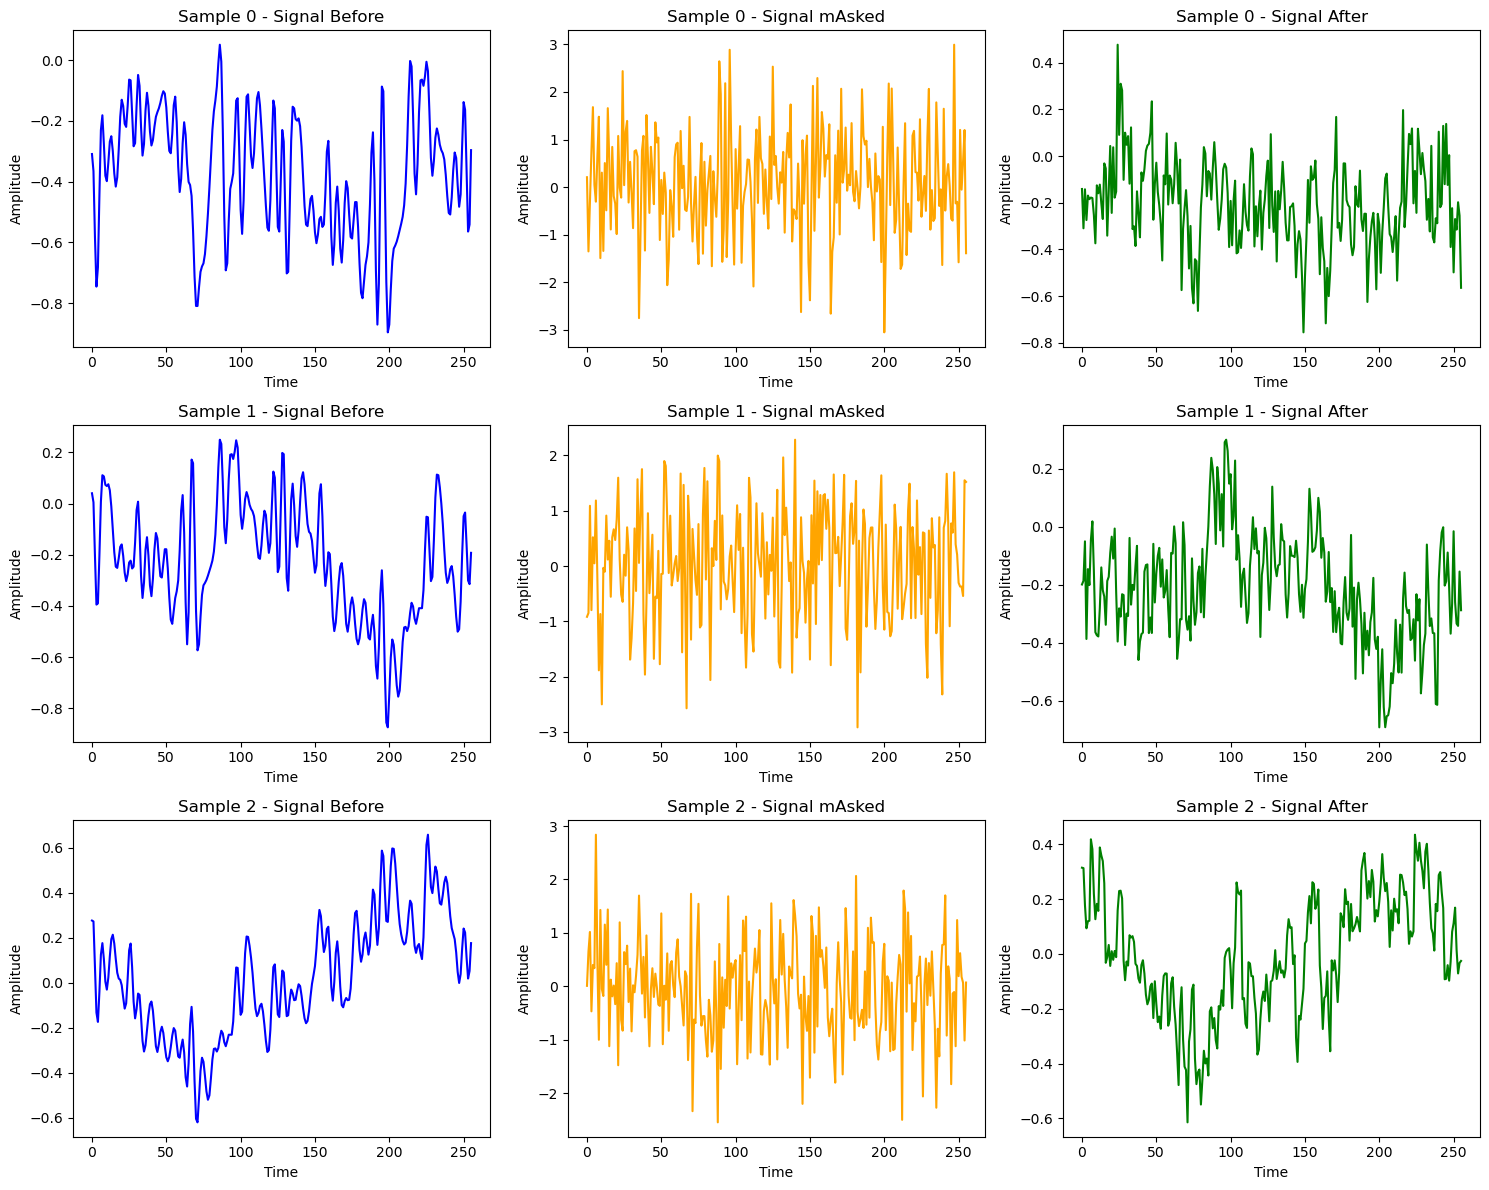

Training completed.
Best Validation Accuracy: 7.16%


In [66]:
sample_idxs = [0, 1, 2]
final_fig = visualize_signals_grid(x, noise_final, x_hat_final, sample_idxs, channel=0)
wandb.log({"Final_EEG_Signals": wandb.Image(final_fig)})
plt.show()

print("Training completed.")
print(f"Best Validation Accuracy: {best_acc*100:.2f}%")